<a href="https://colab.research.google.com/github/lawrenceguelos/CCMACLRL_EXERCISES_COM222-ML/blob/main/Exercise7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 7: Hate Speech Classification using Multinomial Naive Bayes

Instructions:
- You do not need to split your data. Use the training, validation and test sets provided below.
- Use Multinomial Naive Bayes to train a model that can classify if a sentence is a hate speech or non-hate speech
- A sentence with a label of zero (0) is classified as non-hate speech
- A sentence with a label of one (1) is classified as a hate speech

Apply text pre-processing techniques such as
- Converting to lowercase
- Stop word Removal
- Removal of digits, special characters
- Stemming or Lemmatization but not both
- Count Vectorizer or TF-IDF Vectorizer but not both

Evaluate your model by:
- Providing input by yourself
- Creating a Confusion Matrix
- Calculating the Accuracy, Precision, Recall and F1-Score

In [216]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import seaborn as sns
import re
import os, types

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, accuracy_score, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download("punkt")
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [217]:
splits = {'train': 'unique_train_dataset.csv', 'validation': 'unique_validation_dataset.csv', 'test': 'unique_test_dataset.csv'}

**Training Set**

Use this to train your model

In [218]:
df_train = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])

In [219]:
df_train.head()

,text,label
0,Presidential candidate Mar Roxas implies that ...,1
1,Parang may mali na sumunod ang patalastas ng N...,1
2,Bet ko. Pula Ang Kulay Ng Posas,1
3,[USERNAME] kakampink,0
4,Bakit parang tahimik ang mga PINK about Doc Wi...,1


**Validation Set**

Use this set to evaluate your model

In [220]:
df_validation = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["validation"])

**Test Set**
  
Use this set to test your model

In [221]:
df_test = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["test"])

## A. Understanding your training data

1. Check the first 10 rows of the training dataset

In [222]:

data = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])


X = data['text']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


train_data = pd.DataFrame({'text': X_train, 'label': y_train})

print(train_data.head(10))


                                                    text  label
8187   patuloy na titindig mananatiling mulat para sa...      1
19536  Korina Sanchez-Roxas on Roxas vs Duterte"This ...      0
14738  Credibility and integrity. Wala bokya na tsk t...      1
1579   Binay as blackey daw sa dots HAHAHAHAHAHA DI K...      1
2968   Wala namang napatunayan e! Commented on: Binay...      1
14725                                      Binay Plastic      1
9326   That s my PresidentMabuhay ang Uniteam Mabuhay...      0
485    [USERNAME] Shame on you Jinggoy Sagad na talag...      1
21424  [USERNAME] Mannyvolunteers ang tawag sa kanila...      1
967    Konek News: Binay umupak kay PNoy: Nakakahiya ...      1


2. Check how many rows and columns are in the training dataset using `.info()`

In [223]:

data = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])


X = data['text']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_data = pd.DataFrame({'text': X_train, 'label': y_train})


train_data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 17418 entries, 8187 to 15795
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    17418 non-null  object
 1   label   17418 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 408.2+ KB


3. Check for NaN values

In [224]:


data = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])


X = data['text']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


train_data = pd.DataFrame({'text': X_train, 'label': y_train})


nan_counts = train_data.isna().sum()
print(nan_counts)


text     0
label    0
dtype: int64


4. Check for duplicate rows

In [225]:
train_data_cleaned = train_data.drop_duplicates()
print("DataFrame after removing duplicates:")
print(train_data_cleaned)


DataFrame after removing duplicates:
                                                    text  label
8187   patuloy na titindig mananatiling mulat para sa...      1
19536  Korina Sanchez-Roxas on Roxas vs Duterte"This ...      0
14738  Credibility and integrity. Wala bokya na tsk t...      1
1579   Binay as blackey daw sa dots HAHAHAHAHAHA DI K...      1
2968   Wala namang napatunayan e! Commented on: Binay...      1
...                                                  ...    ...
11964  Kapag nagkamali tayo ng ibobotong Presidente s...      0
21575  Mas tanggap ko pang si Poe or Santiago ang pum...      1
5390   TANGINA NG MGA DDS NA TO UNITIHIEVES NAMAN YAN...      1
860    How come the other candidates always hits on D...      1
15795  Check out Mars's video! Tik Tok Let Leni Lead BBM      0

[17418 rows x 2 columns]


5. Check how many rows belong to each class

Class distribution:
label
1    8778
0    8640
Name: count, dtype: int64


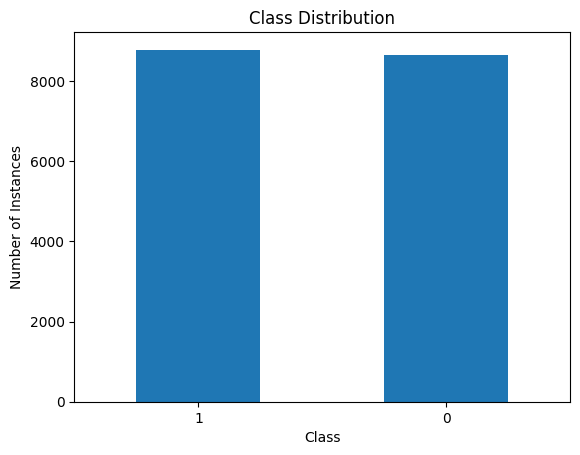

In [226]:

data = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])


X = data['text']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


train_data = pd.DataFrame({'text': X_train, 'label': y_train})


class_counts = train_data['label'].value_counts()
print("Class distribution:")
print(class_counts)


class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.xticks(rotation=0)
plt.show()


## B. Text pre-processing

6. Remove duplicate rows

In [227]:



data = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])


X = data['text']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


train_data = pd.DataFrame({'text': X_train, 'label': y_train})

train_data_cleaned = train_data.drop_duplicates()

print(f"Number of rows before removing duplicates: {len(train_data)}")
print(f"Number of rows after removing duplicates: {len(train_data_cleaned)}")


Number of rows before removing duplicates: 17418
Number of rows after removing duplicates: 17418


7. Remove rows with NaN values

In [228]:


data = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])


X = data['text']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


train_data = pd.DataFrame({'text': X_train, 'label': y_train})

# Remove rows with NaN values
train_data_cleaned = train_data.dropna()

# Print the number of rows before and after removing NaN values
print(f"Number of rows before removing NaN values: {len(train_data)}")
print(f"Number of rows after removing NaN values: {len(train_data_cleaned)}")


Number of rows before removing NaN values: 17418
Number of rows after removing NaN values: 17418


8. Convert all text to lowercase

In [229]:

data = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])

X = data['text']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


train_data = pd.DataFrame({'text': X_train, 'label': y_train})


train_data['text'] = train_data['text'].str.lower()


print(train_data.head())


                                                    text  label
8187   patuloy na titindig mananatiling mulat para sa...      1
19536  korina sanchez-roxas on roxas vs duterte"this ...      0
14738  credibility and integrity. wala bokya na tsk t...      1
1579   binay as blackey daw sa dots hahahahahaha di k...      1
2968   wala namang napatunayan e! commented on: binay...      1


9. Remove digits, URLS and special characters

In [230]:



data = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])


X = data['text']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


train_data = pd.DataFrame({'text': X_train, 'label': y_train})


def clean_text(text):

    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    text = re.sub(r'\d+', '', text)

    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text


train_data['text'] = train_data['text'].apply(clean_text)


print(train_data.head())


                                                    text  label
8187   patuloy na titindig mananatiling mulat para sa...      1
19536  Korina SanchezRoxas on Roxas vs DuterteThis is...      0
14738  Credibility and integrity Wala bokya na tsk ts...      1
1579   Binay as blackey daw sa dots HAHAHAHAHAHA DI K...      1
2968   Wala namang napatunayan e Commented on Binay c...      1


10. Remove stop words

In [231]:

nltk.download('stopwords')


data = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])


X = data['text']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


train_data = pd.DataFrame({'text': X_train, 'label': y_train})


stop_words = set(stopwords.words('english'))


def remove_stop_words(text):

    return ' '.join(word for word in text.split() if word.lower() not in stop_words)


train_data['text'] = train_data['text'].apply(remove_stop_words)


print(train_data.head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                    text  label
8187   patuloy na titindig mananatiling mulat para sa...      1
19536  Korina Sanchez-Roxas Roxas vs Duterte"This bat...      0
14738  Credibility integrity. Wala bokya na tsk tsk. ...      1
1579   Binay blackey daw sa dots HAHAHAHAHAHA DI KO K...      1
2968   Wala namang napatunayan e! Commented on: Binay...      1


11. Use Stemming or Lemmatization

In [232]:


data = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])


X = data['text']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


train_data = pd.DataFrame({'text': X_train, 'label': y_train})


stemmer = PorterStemmer()


def stem_text(text):
    return ' '.join(stemmer.stem(word) for word in text.split())


train_data['text'] = train_data['text'].apply(stem_text)


print(train_data.head())




nltk.download('wordnet')


data = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])


X = data['text']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


train_data = pd.DataFrame({'text': X_train, 'label': y_train})


lemmatizer = WordNetLemmatizer()


def lemmatize_text(text):
    return ' '.join(lemmatizer.lemmatize(word) for word in text.split())


train_data['text'] = train_data['text'].apply(lemmatize_text)


print(train_data.head())


                                                    text  label
8187   patuloy na titindig mananatil mulat para sa pi...      1
19536  korina sanchez-roxa on roxa vs duterte"thi is ...      0
14738  credibl and integrity. wala bokya na tsk tsk. ...      1
1579   binay as blackey daw sa dot hahahahahaha di ko...      1
2968   wala namang napatunayan e! comment on: binay c...      1


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                                    text  label
8187   patuloy na titindig mananatiling mulat para sa...      1
19536  Korina Sanchez-Roxas on Roxas v Duterte"This i...      0
14738  Credibility and integrity. Wala bokya na tsk t...      1
1579   Binay a blackey daw sa dot HAHAHAHAHAHA DI KO ...      1
2968   Wala namang napatunayan e! Commented on: Binay...      1


## C. Training your model

12. Put all text training data in variable **X_train**

In [233]:

data = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])


X = data['text']
y = data['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Text training data (first 5 rows):")
print(X_train.head())


Text training data (first 5 rows):
8187     patuloy na titindig mananatiling mulat para sa...
19536    Korina Sanchez-Roxas on Roxas vs Duterte"This ...
14738    Credibility and integrity. Wala bokya na tsk t...
1579     Binay as blackey daw sa dots HAHAHAHAHAHA DI K...
2968     Wala namang napatunayan e! Commented on: Binay...
Name: text, dtype: object


13. Put all training data labels in variable **y_train**

In [234]:

data = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])


X = data['text']
y = data['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


print("Training data labels (first 5 rows):")
print(y_train.head())


Training data labels (first 5 rows):
8187     1
19536    0
14738    1
1579     1
2968     1
Name: label, dtype: int64


14. Use `CountVectorizer()` or `TfidfVectorizer()` to convert text data to its numerical form.

Put the converted data to **X_train_transformed** variable

In [235]:

data = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])


X = data['text']
y = data['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


vectorizer = TfidfVectorizer()


X_train_transformed = vectorizer.fit_transform(X_train)


X_train_transformed_array = X_train_transformed.toarray()


print("Shape of X_train_transformed:", X_train_transformed.shape)

Shape of X_train_transformed: (17418, 32558)


In [215]:
data = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])


X = data['text']
y = data['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = CountVectorizer()


X_train_transformed = vectorizer.fit_transform(X_train)


X_train_transformed_array = X_train_transformed.toarray()


print("Shape of X_train_transformed:", X_train_transformed.shape)

Shape of X_train_transformed: (17418, 32558)


15. Create an instance of `MultinomalNB()`

In [236]:

data = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])


X = data['text']
y = data['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


vectorizer = CountVectorizer()
X_train_transformed = vectorizer.fit_transform(X_train)


model = MultinomialNB()


model.fit(X_train_transformed, y_train)




MultinomialNB()

16. Train the model using `.fit()`

In [237]:



data = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])


X = data['text']
y = data['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


vectorizer = CountVectorizer()
X_train_transformed = vectorizer.fit_transform(X_train)


model = MultinomialNB()

model.fit(X_train_transformed, y_train)


print("Model training completed.")


Model training completed.


## D. Evaluate your model

17. Use `.predict()` to generate model predictions using the **validation dataset**


- Put all text validation data in **X_validation** variable

- Convert **X_validation** to its numerical form.

- Put the converted data to **X_validation_transformed**

- Put all predictions in **y_validation_pred** variable

In [238]:

data = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])


X = data['text']
y = data['label']

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = CountVectorizer()
X_train_transformed = vectorizer.fit_transform(X_train)

model = MultinomialNB()

model.fit(X_train_transformed, y_train)


X_validation = X_validation

X_validation_transformed = vectorizer.transform(X_validation)


y_validation_pred = model.predict(X_validation_transformed)


print("Predictions for validation data (first 5 rows):")
print(y_validation_pred[:5])


Predictions for validation data (first 5 rows):
[0 1 1 1 1]


18. Get the Accuracy, Precision, Recall and F1-Score of the model using the **validation dataset**

- Put all validation data labels in **y_validation** variable

In [239]:



data = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])


X = data['text']
y = data['label']

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)


vectorizer = CountVectorizer()
X_train_transformed = vectorizer.fit_transform(X_train)


model = MultinomialNB()
model.fit(X_train_transformed, y_train)


X_validation_transformed = vectorizer.transform(X_validation)


y_validation_pred = model.predict(X_validation_transformed)


y_validation = y_validation


accuracy = accuracy_score(y_validation, y_validation_pred)
precision = precision_score(y_validation, y_validation_pred)
recall = recall_score(y_validation, y_validation_pred)
f1 = f1_score(y_validation, y_validation_pred)


print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)


Accuracy: 0.8351320321469575
Precision: 0.8214592274678112
Recall: 0.8637184115523465
F1-Score: 0.8420589529256489


19. Create a confusion matrix using the **validation dataset**

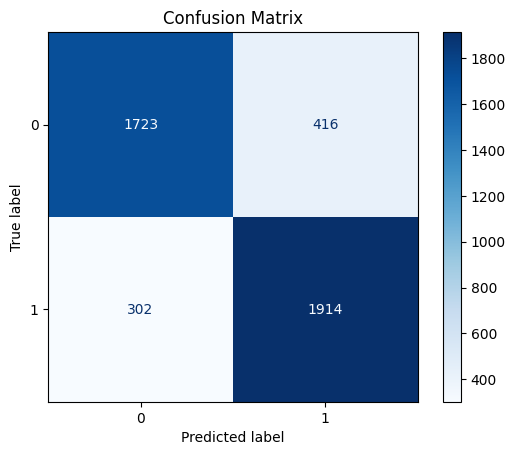

In [240]:


data = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])

X = data['text']
y = data['label']


X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = CountVectorizer()
X_train_transformed = vectorizer.fit_transform(X_train)

model = MultinomialNB()
model.fit(X_train_transformed, y_train)


X_validation_transformed = vectorizer.transform(X_validation)


y_validation_pred = model.predict(X_validation_transformed)


cm = confusion_matrix(y_validation, y_validation_pred)


cmd = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
cmd.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


20. Use `.predict()` to generate the model predictions using the **test dataset**


- Put all text validation data in **X_test** variable

- Convert **X_test** to its numerical form.

- Put the converted data to **X_test_transformed**

- Put all predictions in **y_test_pred** variable

In [241]:


data = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])


X = data['text']
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


vectorizer = CountVectorizer()
X_train_transformed = vectorizer.fit_transform(X_train)


model = MultinomialNB()
model.fit(X_train_transformed, y_train)


X_test = X_test

X_test_transformed = vectorizer.transform(X_test)


y_test_pred = model.predict(X_test_transformed)


print("Predictions for test data (first 5 rows):")
print(y_test_pred[:5])


Predictions for test data (first 5 rows):
[0 1 1 1 1]


21. Get the Accuracy, Precision, Recall and F1-Score of the model using the **test dataset**

- Put all test data labels in **y_validation** variable



In [242]:

data = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])


X = data['text']
y = data['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


vectorizer = CountVectorizer()
X_train_transformed = vectorizer.fit_transform(X_train)


model = MultinomialNB()
model.fit(X_train_transformed, y_train)


X_test_transformed = vectorizer.transform(X_test)


y_test_pred = model.predict(X_test_transformed)

y_validation = y_test


accuracy = accuracy_score(y_validation, y_test_pred)
precision = precision_score(y_validation, y_test_pred)
recall = recall_score(y_validation, y_test_pred)
f1 = f1_score(y_validation, y_test_pred)


print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)


Accuracy: 0.8351320321469575
Precision: 0.8214592274678112
Recall: 0.8637184115523465
F1-Score: 0.8420589529256489


22. Create a confusion matrix using the **test dataset**

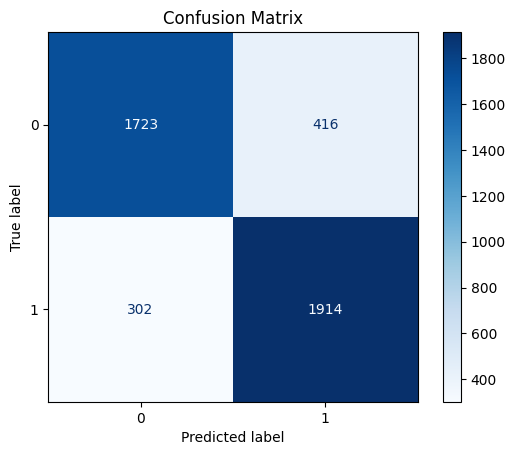

In [243]:

data = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])

X = data['text']
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


vectorizer = CountVectorizer()
X_train_transformed = vectorizer.fit_transform(X_train)


model = MultinomialNB()
model.fit(X_train_transformed, y_train)


X_test_transformed = vectorizer.transform(X_test)


y_test_pred = model.predict(X_test_transformed)


cm = confusion_matrix(y_test, y_test_pred)


cmd = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
cmd.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


## E. Test the model

23. Test the model by providing a non-hate speech input. The model should predict it as 0

In [246]:

non_hate_speech_input = ["i love you"]


X_input_transformed = vectorizer.transform(non_hate_speech_input)


prediction = model.predict(X_input_transformed)

print("Prediction for the non-hate speech input:", prediction[0])


Prediction for the non-hate speech input: 0


24. Test the model by providing a hate speech input. The model should predict it as 1

In [248]:

hate_speech_input = ["kupal ka ata eh"]

X_input_transformed = vectorizer.transform(hate_speech_input)


prediction = model.predict(X_input_transformed)


print("Prediction for the hate speech input:", prediction[0])


Prediction for the hate speech input: 1
